In [1]:
import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel

np.random.seed(666) #just for reaptable results

def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

In [16]:
dfx = pd.read_excel('./CRC.xlsx', sheet_name='data')
dfx = dfx[dfx.columns[1:]]
dfx = np.log(dfx + 1e-8)

feature_groups_df = pd.read_excel('./CRC.xlsx', sheet_name='feature_info')
feature_group_list = feature_groups_df.Group.tolist()

dfy_all = pd.read_excel('./CRC.xlsx', sheet_name='sample_info')
dfy = pd.get_dummies(dfy_all['Group'])



X = dfx.values.astype(float)
Y = dfy.values.astype(float)


In [17]:
model_save_path = './model'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

In [4]:
mp = AggMap(dfx, metric = 'correlation')
mp.fit(cluster_channels = 5, verbose = 0)

mp.save(os.path.join(model_save_path, 'aggmap.mp'))

2020-10-14 18:12:47,531 - INFO - [bidd-aggmap] - Calculating distance ...
2020-10-14 18:12:47,576 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 849/849 [00:01<00:00, 797.40it/s]


2020-10-14 18:13:00,429 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-10-14 18:13:05,341 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-10-14 18:13:06,771 - INFO - [bidd-aggmap] - Finished


['./model/aggmap.mp']

## 5 countries to countries cross validation

In [18]:
country_idx = dfy_all.groupby(['Country']).apply(lambda x:x.index.tolist())
country_idx

Country
AUS    [114, 115, 116, 117, 118, 119, 120, 121, 122, ...
CHI    [223, 224, 225, 226, 227, 228, 229, 230, 231, ...
FRA    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
GER    [455, 456, 457, 458, 459, 460, 461, 462, 463, ...
USA    [351, 352, 353, 354, 355, 356, 357, 358, 359, ...
dtype: object

In [19]:
country_names = country_idx.index.tolist()

In [7]:
#study to study transfer

run_all = []
for train_country in country_names:

    train_idx = country_idx.loc[train_country]

    trainx = X[train_idx]
    trainY = Y[train_idx]
    trainX = mp.batch_transform(trainx, scale_method = 'standard')        

    clf = AggModel.MultiClassEstimator(epochs = 30,  batch_size = 1, 
                                       conv1_kernel_size = 5, 
                                       verbose = 0, gpuid = 1)
    clf.fit(trainX, trainY)  
    
    ## save model
    clf._model.save(os.path.join(model_save_path, '%s.h5' % train_country))
    
    for test_country in country_names:
        
        test_idx = country_idx.loc[test_country]
        testY = Y[test_idx]
        testx = X[test_idx]

        testX = mp.batch_transform(testx, scale_method = 'standard')
        print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

        y_true = testY[:,0]
        y_pred = clf.predict(testX)[:,0]
        y_score = clf.predict_proba(testX)[:,0]

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        acc = (tp + tn) / sum([tn, fp, fn, tp])

        sensitivity = tp / sum([tp, fn])
        specificity = tn / sum([tn, fp])

        prc_auc = prc_auc_score(y_true, y_score)
        roc_auc = roc_auc_score(y_true, y_score)

        precision = tp / sum([tp, fp])
        recall =  tp / sum([tp, fn]) #equals to sensitivity


        res = {'train_country': train_country,
               'test_country':test_country,

               'accuracy':acc, 

               'prc_auc':prc_auc, 
               'roc_auc':roc_auc,

               'sensitivity': sensitivity, 
               'specificity': specificity,

               'precision':precision,
               'recall':recall,
              }

        run_all.append(res)

100%|##########| 109/109 [00:02<00:00, 39.73it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='1')


100%|##########| 109/109 [00:00<00:00, 507.43it/s]



 input train and test X shape is (109, 30, 29, 5), (109, 30, 29, 5) 


  0%|          | 0/114 [00:00<?, ?it/s]


 input train and test X shape is (109, 30, 29, 5), (128, 30, 29, 5) 


  0%|          | 0/120 [00:00<?, ?it/s]


 input train and test X shape is (109, 30, 29, 5), (114, 30, 29, 5) 


  0%|          | 0/104 [00:00<?, ?it/s]


 input train and test X shape is (109, 30, 29, 5), (120, 30, 29, 5) 


  0%|          | 0/128 [00:00<?, ?it/s]


 input train and test X shape is (109, 30, 29, 5), (104, 30, 29, 5) 


100%|##########| 128/128 [00:00<00:00, 608.45it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='1')


  0%|          | 0/128 [00:00<?, ?it/s]


 input train and test X shape is (128, 30, 29, 5), (109, 30, 29, 5) 


 51%|#####     | 58/114 [00:00<00:00, 536.94it/s]


 input train and test X shape is (128, 30, 29, 5), (128, 30, 29, 5) 


  0%|          | 0/120 [00:00<?, ?it/s]


 input train and test X shape is (128, 30, 29, 5), (114, 30, 29, 5) 


 56%|#####5    | 58/104 [00:00<00:00, 529.71it/s]


 input train and test X shape is (128, 30, 29, 5), (120, 30, 29, 5) 


  0%|          | 0/114 [00:00<?, ?it/s]


 input train and test X shape is (128, 30, 29, 5), (104, 30, 29, 5) 


100%|##########| 114/114 [00:00<00:00, 490.80it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='1')


 38%|###7      | 48/128 [00:00<00:00, 463.64it/s]


 input train and test X shape is (114, 30, 29, 5), (109, 30, 29, 5) 


  0%|          | 0/114 [00:00<?, ?it/s]


 input train and test X shape is (114, 30, 29, 5), (128, 30, 29, 5) 


  0%|          | 0/120 [00:00<?, ?it/s]


 input train and test X shape is (114, 30, 29, 5), (114, 30, 29, 5) 


 56%|#####5    | 58/104 [00:00<00:00, 526.65it/s]


 input train and test X shape is (114, 30, 29, 5), (120, 30, 29, 5) 


 40%|####      | 48/120 [00:00<00:00, 460.68it/s]


 input train and test X shape is (114, 30, 29, 5), (104, 30, 29, 5) 


100%|##########| 120/120 [00:00<00:00, 560.03it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='1')


 45%|####5     | 58/128 [00:00<00:00, 544.72it/s]


 input train and test X shape is (120, 30, 29, 5), (109, 30, 29, 5) 


  0%|          | 0/114 [00:00<?, ?it/s]


 input train and test X shape is (120, 30, 29, 5), (128, 30, 29, 5) 


 48%|####8     | 58/120 [00:00<00:00, 528.73it/s]


 input train and test X shape is (120, 30, 29, 5), (114, 30, 29, 5) 


 56%|#####5    | 58/104 [00:00<00:00, 532.29it/s]


 input train and test X shape is (120, 30, 29, 5), (120, 30, 29, 5) 


 46%|####6     | 48/104 [00:00<00:00, 429.51it/s]


 input train and test X shape is (120, 30, 29, 5), (104, 30, 29, 5) 


100%|##########| 104/104 [00:00<00:00, 503.61it/s]


MultiClassEstimator(batch_size=1, conv1_kernel_size=5, epochs=30, gpuid='1')


  0%|          | 0/128 [00:00<?, ?it/s]


 input train and test X shape is (104, 30, 29, 5), (109, 30, 29, 5) 


  0%|          | 0/114 [00:00<?, ?it/s]


 input train and test X shape is (104, 30, 29, 5), (128, 30, 29, 5) 


  0%|          | 0/120 [00:00<?, ?it/s]


 input train and test X shape is (104, 30, 29, 5), (114, 30, 29, 5) 


 56%|#####5    | 58/104 [00:00<00:00, 534.33it/s]


 input train and test X shape is (104, 30, 29, 5), (120, 30, 29, 5) 


100%|##########| 104/104 [00:00<00:00, 557.34it/s]



 input train and test X shape is (104, 30, 29, 5), (104, 30, 29, 5) 


In [8]:
clf._model.count_params()

300098

In [9]:
df = pd.DataFrame(run_all)
df.to_csv('./run_all.csv')
df

,train_country,test_country,accuracy,prc_auc,roc_auc,sensitivity,specificity,precision,recall
0,AUS,AUS,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,AUS,CHI,0.703125,0.813108,0.746246,0.567568,0.888889,0.875000,0.567568
2,AUS,FRA,0.710526,0.783998,0.753789,0.603774,0.803279,0.727273,0.603774
3,AUS,GER,0.833333,0.914126,0.887500,0.716667,0.950000,0.934783,0.716667
4,AUS,USA,0.721154,0.811904,0.781065,0.557692,0.884615,0.828571,0.557692
5,CHI,AUS,0.724771,0.797203,0.820566,0.717391,0.730159,0.660000,0.717391
6,CHI,CHI,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,CHI,FRA,0.692982,0.795018,0.793999,0.754717,0.639344,0.645161,0.754717
8,CHI,GER,0.800000,0.903254,0.895833,0.683333,0.916667,0.891304,0.683333
9,CHI,USA,0.634615,0.761357,0.762944,0.557692,0.711538,0.659091,0.557692


In [10]:
dfres = pd.crosstab(index = df.train_country, columns= df.test_country, values= df.roc_auc, aggfunc = np.mean)

In [11]:
dfres.to_excel('study2study_results_ROC.xlsx')

In [2]:
dfres = pd.read_excel('study2study_results_ROC.xlsx',index_col='train_country')

dfres = dfres.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'},
                    index =  {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'}
                    )

dfres

,AUS,CHN,FRA,DEU,USA
train_country,,,,,
AUS,1.000000,0.746246,0.753789,0.887500,0.781065
CHN,0.820566,1.000000,0.793999,0.895833,0.762944
FRA,0.879917,0.864239,1.000000,0.923889,0.768121
DEU,0.856453,0.857357,0.811011,1.000000,0.779956
USA,0.855763,0.764264,0.692236,0.811389,1.000000


In [3]:
cols = ['FRA', 'AUS', 'CHN', 'USA', 'DEU']

In [4]:
ourmodel_df = dfres[cols].loc[cols].round(3)
ourmodel_df

,FRA,AUS,CHN,USA,DEU
train_country,,,,,
FRA,1.000,0.880,0.864,0.768,0.924
AUS,0.754,1.000,0.746,0.781,0.888
CHN,0.794,0.821,1.000,0.763,0.896
USA,0.692,0.856,0.764,1.000,0.811
DEU,0.811,0.856,0.857,0.780,1.000


In [5]:
y = """Training set	Test set	AUC
FRA	FRA	0.838230745
FRA	DEU	0.831666667
FRA	CHN	0.826576577
FRA	USA	0.642381657
FRA	AUS	0.768806073
DEU	FRA	0.84441695
DEU	DEU	0.7875
DEU	CHN	0.877877878
DEU	USA	0.743713018
DEU	AUS	0.777777778
CHN	FRA	0.825549026
CHN	DEU	0.830833333
CHN	CHN	0.826076076
CHN	USA	0.669378698
CHN	AUS	0.764665286
USA	FRA	0.751005258
USA	DEU	0.788888889
USA	CHN	0.696946947
USA	USA	0.729659763
USA	AUS	0.777432712
AUS	FRA	0.628518404
AUS	DEU	0.651944444
AUS	CHN	0.741991992
AUS	USA	0.589497041
AUS	AUS	0.911663216""" 
pres = [i.split('\t') for i in y.split('\n')]

previous_df = pd.DataFrame(pres[1:], columns=pres[0])
previous_df['AUC'] = previous_df['AUC'].astype('float')
previous_df = pd.pivot_table(previous_df, values='AUC', index='Training set', columns='Test set')

previous_df

Test set,AUS,CHN,DEU,FRA,USA
Training set,,,,,
AUS,0.911663,0.741992,0.651944,0.628518,0.589497
CHN,0.764665,0.826076,0.830833,0.825549,0.669379
DEU,0.777778,0.877878,0.787500,0.844417,0.743713
FRA,0.768806,0.826577,0.831667,0.838231,0.642382
USA,0.777433,0.696947,0.788889,0.751005,0.729660


In [6]:
ourmodel_df = ourmodel_df.loc[previous_df.index][previous_df.columns]
ourmodel_df

,AUS,CHN,DEU,FRA,USA
Training set,,,,,
AUS,1.000,0.746,0.888,0.754,0.781
CHN,0.821,1.000,0.896,0.794,0.763
DEU,0.856,0.857,1.000,0.811,0.780
FRA,0.880,0.864,0.924,1.000,0.768
USA,0.856,0.764,0.811,0.692,1.000


In [7]:
def get_non_diag_mean(df):
    v = df.values.copy()
    
    np.fill_diagonal(v, np.nan)
    
    mean =  pd.DataFrame(v, columns = df.columns, index = df.index).mean(axis=1).round(2)
    std = pd.DataFrame(v, columns = df.columns, index = df.index).std(axis=1).round(2)
    return mean,std

In [8]:
get_non_diag_mean(previous_df)[0].mean()

0.75

In [9]:
get_non_diag_mean(ourmodel_df)[0].mean()

0.8160000000000001

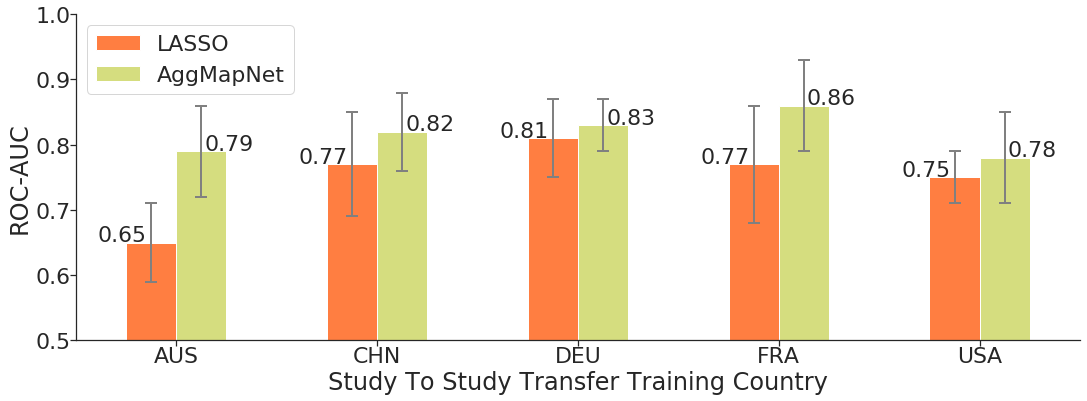

In [16]:
sns.set(style = 'white', font_scale=2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6), sharex = True, sharey = True)

y1 = get_non_diag_mean(previous_df)[0].to_frame(name = 'LASSO')
y2 = get_non_diag_mean(ourmodel_df)[0].to_frame(name = 'AggMapNet')

y1_err = get_non_diag_mean(previous_df)[1].to_frame(name = 'LASSO')
y2_err = get_non_diag_mean(ourmodel_df)[1].to_frame(name = 'AggMapNet')

y = y1.join(y2)
y_err = y1_err.join(y2_err)

color = sns.color_palette("rainbow_r", 5) #PiYG

y.plot(kind = 'bar',ax = ax, color = color, yerr= y_err,ylim = (0.5, 0.96), error_kw=dict(ecolor='gray', lw=2, capsize=6, capthick=2))
ax.set_ylabel('ROC-AUC')
#ax.set_title('Study To Study Transfer (STST) Average Performance')
ax.set_xlabel('Study To Study Transfer Training Country')

for x_, y_ in enumerate(y['LASSO'].values):
    ax.annotate('%.2f' % y_, xy = (x_-0.39, y_+0.002), fontsize =22)

for  x_, y_ in enumerate(y['AggMapNet'].values):
    ax.annotate('%.2f' % y_, xy = (x_+0.14, y_+0.002), fontsize =22)
    
ax.set_xticklabels(labels = y.index,rotation=0, ha = 'center')
ax.set_ylim(0.5,1.0)


ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)


fig.savefig('./results/STST_loso_aggmap_vs_lasso__comparasion_mean.pdf', bbox_inches='tight', dpi=400) 

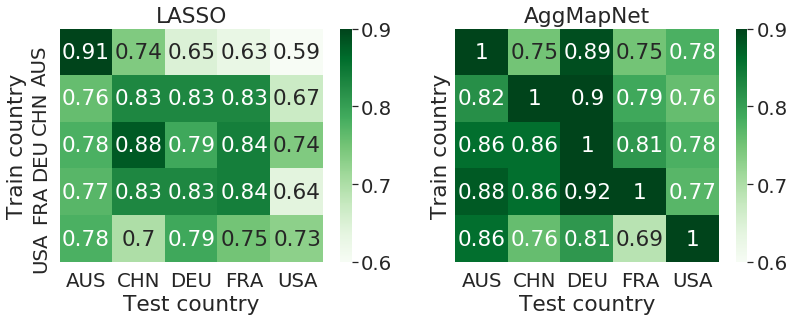

In [30]:
sns.set(style = 'white', font_scale=1.8)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4.3), sharex=True, sharey=True)

ax2, ax1 = axes

sns.heatmap(ourmodel_df.round(2), cmap = 'Greens',  ax = ax1, annot=True,  vmin = 0.6, vmax = 0.9,)
ax1.set_title("AggMapNet")

sns.heatmap(previous_df.round(2), cmap = 'Greens',  ax = ax2, annot=True, vmin = 0.6, vmax = 0.9,)
ax2.set_title("LASSO")

ax1.set_ylabel('Train country')
ax2.set_ylabel('Train country')

ax1.set_xlabel('Test country')
ax2.set_xlabel('Test country')


fig.savefig('./results/STST_loso_aggmap_vs_lasso_comparasion_all.pdf', bbox_inches='tight', dpi=400) 

In [28]:
#number of samples
res = {}
for train_country in country_names:

    train_idx = country_idx.loc[train_country]

    trainx = X[train_idx]
    trainY = Y[train_idx]
    
    ntr = len(trainx)
    for test_country in country_names:
        
        if test_country == train_country:
            continue
            
        test_idx = country_idx.loc[test_country]
        testY = Y[test_idx]
        testx = X[test_idx]
        nts = len(testx)
        n = nts + ntr
        
        res.update({'%s-%s' % (train_country, test_country) :n })

In [29]:
pd.DataFrame([res]).T

,0
AUS-CHI,237
AUS-FRA,223
AUS-GER,229
AUS-USA,213
CHI-AUS,237
CHI-FRA,242
CHI-GER,248
CHI-USA,232
FRA-AUS,223
FRA-CHI,242
